In [1]:
# this notebook explores the winrate relation to time of day, for opponents

In [37]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.cluster import KMeans
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from math import acos, sqrt, pi, cos, sin
import datetime

In [3]:
def timestamp_to_radians(unix_timestamp):
    time = datetime.datetime.fromtimestamp(unix_timestamp)
    total_seconds = time.hour * 3600 + time.minute * 60 + time.second
    seconds_in_day = 24 * 60 * 60
    radians = (total_seconds / seconds_in_day) * 2 * pi
    return radians

In [4]:
tyler_df = pd.read_csv('tyler_24h.csv').dropna()
opp_history_df = pd.read_csv('opp_24h.csv').dropna()

In [5]:
for df in [tyler_df, opp_history_df]:
    cos_col = {}
    sin_col = {}
    for index, row in df.iterrows():
        radians = timestamp_to_radians(row['unix'])
        cos_col[index] = cos(radians)
        sin_col[index] = sin(radians)
    df['24h_cos'] = cos_col
    df['24h_sin'] = sin_col

In [28]:
tyler_df.head(25)

,unix,player_elo,opp_elo,opp_name,opp_30d,elo_diff,color,player_acc,opp_acc,acc_diff,won,num_reque,time_since_prev,opp_num_reque,opp_time_since_prev,24h_cos,24h_sin
0,1696185098,1090,1063,Quarini,249,27,False,69.43,62.25,7.18,1.0,0,0,2.0,325.0,-0.788995,-0.614400
1,1696186352,1097,1091,hgarciarod,339,6,True,78.20,69.40,8.80,1.0,0,1254,2.0,1108.0,-0.729765,-0.683698
2,1696187659,1105,1139,HERFJERF,113,-34,False,92.66,80.43,12.23,1.0,0,1307,0.0,48092.0,-0.661585,-0.749871
4,1696189372,1113,1105,InkLv,116,8,False,83.82,72.41,11.41,1.0,2,529,1.0,557.0,-0.563286,-0.826262
5,1696190619,1121,1105,alamrini,308,16,True,80.57,78.02,2.55,0.0,3,1247,0.0,5208.0,-0.486145,-0.873878
6,1696191447,1113,1143,djgreen1,193,-30,True,64.50,57.93,6.57,1.0,4,828,3.0,832.0,-0.432676,-0.901550
7,1696192994,1122,1088,Pytoo91,221,34,False,51.35,64.64,-13.29,0.0,0,1547,0.0,1318.0,-0.328729,-0.944424
8,1696193859,1113,1078,mumergaddafi,121,35,True,73.48,58.18,15.30,1.0,1,865,18.0,892.0,-0.268710,-0.963221
9,1696196998,1120,1122,Copertus,505,-2,True,79.47,66.51,12.96,1.0,0,3139,0.0,13265.0,-0.043765,-0.999042
10,1696198095,1128,1109,CyborgCerberus94,42,19,False,65.14,81.79,-16.65,0.0,1,1097,0.0,2098.0,0.035990,-0.999352


In [7]:
opp_history_df.head(5)

,unix,elo,elo_diff,color,won,reference_index,24h_cos,24h_sin
1,1694008792,890,-18,True,0.0,0,-0.865734,0.500504
2,1694009304,882,14,False,0.0,0,-0.883766,0.467930
3,1694110707,874,21,False,0.0,0,-0.823012,-0.568023
4,1694364931,866,-96,True,1.0,0,-0.970804,-0.239875
5,1694366195,876,-56,False,1.0,0,-0.944687,-0.327974


In [29]:
opp_history_ref_index_groups = opp_history_df.groupby('reference_index')

first_opp = opp_history_ref_index_groups.get_group(14)

first_opp

,unix,elo,elo_diff,color,won,reference_index,24h_cos,24h_sin
2971,1693664860,1120,-17,False,0.0,14,-0.919936,0.392070
2972,1693665168,1112,15,True,1.0,14,-0.928486,0.371368
2974,1693667447,1119,-16,True,0.0,14,-0.977030,0.213101
2975,1693668243,1111,20,True,1.0,14,-0.987722,0.156219
2976,1693668922,1119,-27,True,0.0,14,-0.994229,0.107276
...,...,...,...,...,...,...,...,...
4042,1696198571,1109,-27,True,1.0,14,0.070554,-0.997508
4043,1696199155,1118,6,False,0.0,14,0.112842,-0.993613
4044,1696199583,1110,-9,False,1.0,14,0.143709,-0.989620
4045,1696200580,1118,14,True,0.0,14,0.215019,-0.976610


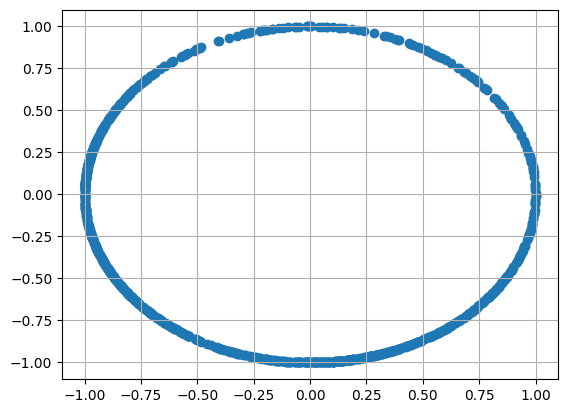

In [36]:
plt.scatter(first_opp['24h_cos'], first_opp['24h_sin'])
plt.grid()
plt.show()

In [41]:
df = first_opp.copy()

# Define the custom metric
def unit_circle_distance(a, b):
    return np.arccos(np.clip(np.dot(a, b), -1.0, 1.0))

avg_scores = {}

for n in range(3, 101, 10):
    # Prepare data
    X = df[['24h_cos', '24h_sin']].values
    y = df['won'].values

    # KNN Classifier with custom metric
    knn = KNeighborsClassifier(n_neighbors=n, metric=unit_circle_distance)

    # 5-fold cross-validation
    kf = KFold(n_splits=5)
    scores = cross_val_score(knn, X, y, cv=kf)

    # Output the cross-validation results
    print("Cross-validation scores:", scores)
    print("Average score:", np.mean(scores))
    avg_scores[n] = np.mean(scores)

# Train KNN on entire dataset for prediction
#knn.fit(X, y)

# Predicting probability for a new data point
#'''new_data = np.array([[cos_value, sin_value]])  # replace cos_value and sin_value with actual values
#probability = knn.predict_proba(new_data)[:, 1]  # Probability of target being 1
#print("Probability of target being 1:", probability)'''


Cross-validation scores: [0.47087379 0.48543689 0.51941748 0.50970874 0.51456311]
Average score: 0.5
Cross-validation scores: [0.49029126 0.4223301  0.4368932  0.46601942 0.51456311]
Average score: 0.4660194174757281
Cross-validation scores: [0.50485437 0.4223301  0.44174757 0.43203883 0.50485437]
Average score: 0.46116504854368934
Cross-validation scores: [0.48058252 0.48543689 0.45631068 0.47572816 0.48058252]
Average score: 0.4757281553398059
Cross-validation scores: [0.46116505 0.40776699 0.43203883 0.47572816 0.53398058]
Average score: 0.46213592233009704
Cross-validation scores: [0.45145631 0.41262136 0.4368932  0.48058252 0.51456311]
Average score: 0.4592233009708738
Cross-validation scores: [0.41747573 0.45145631 0.45145631 0.48058252 0.53398058]
Average score: 0.4669902912621359
Cross-validation scores: [0.44660194 0.39805825 0.48543689 0.52912621 0.51456311]
Average score: 0.4747572815533981
Cross-validation scores: [0.45631068 0.46116505 0.48543689 0.50485437 0.52427184]
Ave

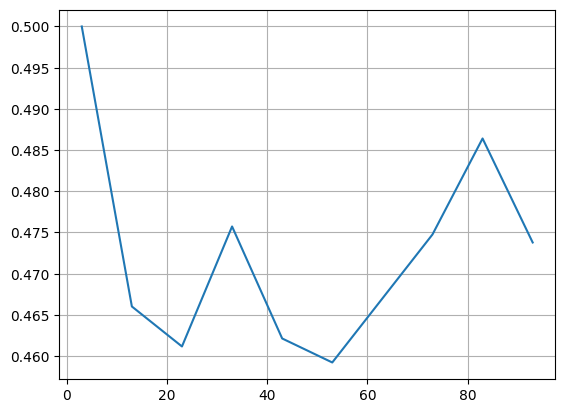

In [42]:
plt.plot(avg_scores.keys(), avg_scores.values())
plt.grid()
plt.show()